# 10.1 생물학적 뉴런에서 인공 뉴런까지

## 10.1.3 퍼셉트론

In [75]:
# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris.target == 0).astype(np.int) # 부채붓꽃(Iris Setosa)인가?

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

C:\Users\dAb\AppData\Local\Temp/ipykernel_15948/2606389078.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris.target == 0).astype(np.int) # 부채붓꽃(Iris Setosa)인가?


In [3]:
y_pred

array([1])

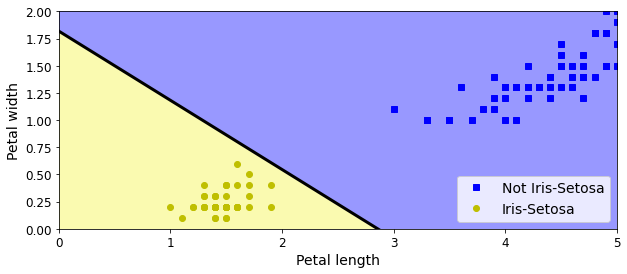

In [4]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

### 로지스틱 회귀 분류기와 달리 퍼셉트론은 클래스 확률을 제공하지 않으며, 고정된 임곗값을 기준으로 예측을 만듦. 이런 이유로 퍼셉트론보다 로지스틱 회귀가 선호됨

## 10.1.4 다층 퍼셉트론과 역전파

## 10.1.5 회귀를 위한 다층 퍼셉트론

|**하이퍼 파라미터**|**일반적인 값**|
|:--|:--|
|입력 뉴런 수|특성마다 하나(예를 들어 MNIST의 경우 28x28=784)|
|은닉층 수|문제에 따라 다름. 일반적으로 1에서 5사이|
|은닉층의 뉴런 수|문제에 따라 다름. 일반적으로 10에서 100사이|
|출력 뉴런 수|예측 차원마다 하나|
|은닉 층의 활성화 함수|ReLU(또는 SeLU)|
|출력층의 활성화 함수|없음, 또는 (출력이 양수일 때) ReLU/softplus나 (출력을 특정 범위로 제한할 때) logistic/tanh를 사용|
|손실함수|MSE나 (이상치가 있다면) MAE/Huber|

## 10.1.6 분류를 위한 다층 퍼셉트론
|**하이퍼 파라미터**|**이진 분류**|**다중 레이블 분류**|**다중 분류**|
|:--|:--|:--|:--|
|입력층과 은닉층|회귀와 동일|회귀와 동일|회귀와 동일|
|출력 뉴런 수|1개|레이블마다 1개|클래스마다 1개|
|출력층의 활성화 함수|로지스틱 함수|로지스틱 함수|소프트맥스 함수|
|손실 함수|크로스 엔트로피|크로스 엔트로피|크로스 엔트로피|

# 10.2 케라스로 다층 퍼셉트론 구현하기

In [5]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.6.0'

In [6]:
keras.__version__

'2.6.0'

## 10.2.2 시퀀셜 API를 사용해 이미지 분류기 만들기

### 케라스를 사용해 데이터셋 적재하기

In [7]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

사이킷런 대신 케라스를 사용해 MNIST 데이터를 적재할 때 중요한 차이점은 각 이미지가 784크기의 1D배열이 아니라 28x28 크기의 배열이라는 것. 또한 픽셀 강도가 실수가 아니라 정수(0에서 255까지)로 표현되어 있음

In [8]:
X_train_full.shape

(60000, 28, 28)

In [9]:
X_train_full.dtype

dtype('uint8')

전체 훈련 세트를 검증 세트와 (조금 더 작은) 훈련 세트로 나누고, 또한 픽셀 강도를 255로 나누어 0~1 범위의 실수로 바꿈

In [10]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

맷플롯립의 imshow() 함수와 'binary' 컬러맵을 사용해 이미지를 출력

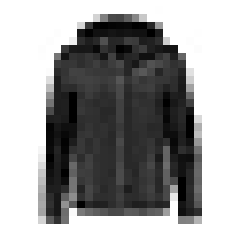

In [14]:
plt.imshow(X_train[0], cmap = 'binary')
plt.axis('off')
plt.show()

레이블은 0에서 9까지 (uint8로 표현된) 클래스 아이디

In [15]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

클래스 이름

In [16]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

훈련 세트에 있는 첫 번째 이미지

In [14]:
class_names[y_train[0]]

'Coat'

검증 세트는 5,000개의 이미지를 담고 있고 테스트 세트는 10,000개의 이미지를 가짐

In [15]:
X_valid.shape

(5000, 28, 28)

In [16]:
X_test.shape

(10000, 28, 28)

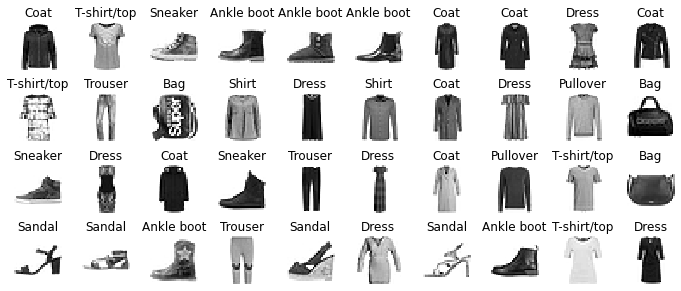

In [17]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
        
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

### 시퀀셜 API를 사용해 모델 만들기

In [18]:
model = keras.models.Sequential()

# 1D 배열로 변환 즉, X를 입력받으면 X.reshape(-1,1)을 계산
# 첫 번째 층이므로 input_shape을 지정
model.add(keras.layers.Flatten(input_shape=[28, 28]))

# 뉴런 300개 가진 Dense 은닉층 추가. Dense 층마다 각자 가중치 행렬 관리
model.add(keras.layers.Dense(300, activation="relu"))

# 뉴런 100개 가진 두 번째 은닉층 추가
model.add(keras.layers.Dense(100, activation="relu"))

# 클래스마다 뉴런 10개를 가진 Dense 출력층을 추가 
# (배타적인 클래스 이므로 소프트맥스 활성화 함수 사용) 
model.add(keras.layers.Dense(10, activation="softmax"))

# activation = "relu" 와 activation = keras.activations.relu로 지정하는 것은 동일함.

In [19]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28, 28]),
#     keras.layers.Dense(300, activation="relu"),
#     keras.layers.Dense(100, activation="relu"),
#     keras.layers.Dense(10, activation="softmax")
# ])

In [20]:
model.layers

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Dense 층은 보통 많은 파라미터를 가짐  
첫 번째 은닉층은 784x300개의 연결 가중치와 300개의 편향을 가짐  
이를 더하면 235,500개가 됨

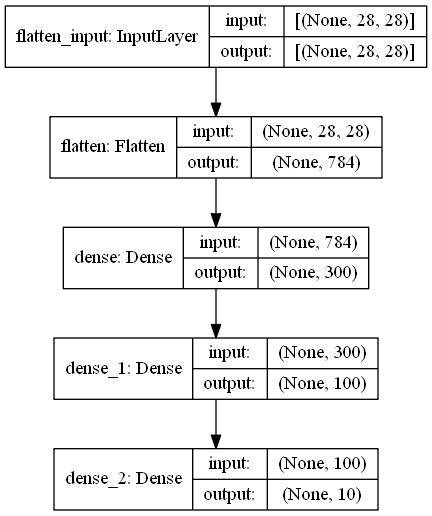

In [22]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [23]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [24]:
model.get_layer(hidden1.name) is hidden1

True

층의 모든 파라미터는 get_weights() 메서드와 set_weights() 메서드를 사용해 접근할 수 있음  
Dense층의 경우 연결 가중치와 편향이 모두 포함되어 있음

In [25]:
weights, biases = hidden1.get_weights()

In [26]:
weights

array([[-0.0373327 ,  0.05936794, -0.04684503, ...,  0.04825711,
        -0.0400525 ,  0.03444849],
       [-0.07059839,  0.04983971,  0.01538973, ...,  0.01542312,
         0.01204916,  0.00877852],
       [-0.06911656,  0.03150337, -0.03155906, ..., -0.00853714,
         0.05770753,  0.02463733],
       ...,
       [-0.06351094,  0.03161256,  0.01533643, ...,  0.03472187,
         0.01876042, -0.00207967],
       [-0.04799716,  0.02149048, -0.02152865, ..., -0.00929394,
        -0.06336529, -0.05411818],
       [ 0.06253299,  0.05954087, -0.0126326 , ...,  0.00566911,
         0.07386211,  0.01337351]], dtype=float32)

In [27]:
weights.shape

(784, 300)

Dense층은 연결 가중치를 무작위로 초기화 / 편향은 0으로 초기화

In [28]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [29]:
biases.shape

(300,)

### 모델 컴파일
모델을 만들고 compile() 메서드를 호출해 사용할 손실함수와 옵티마이저를 지정해야함

샘플마다 타깃 클래스 인덱스 하나가 있고(여기서는 0부터 9까지 정수) 클래스가 배타적이므로 "sparse_categorical_crossentropy"손실을 사용.  
만약 샘플마다 클래스별 타깃 확률을 가지고 있다면 "binary_crossentropy"손실을 사용  
분류기이므로 훈련과 평가 시에 정확도를 측정하기 위해 "accuracy"로 지정  
옵티마이저에 "sgd"를 지정하면 기본 확률적 경사 하강법을 사용해 모델을 훈련

In [30]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

### 모델 훈련과 평가
훈련할 에포크 획수는 지정하지 않으면 기본값이 1이라서 좋은 솔루션으로 수렴하기 충분하지 않음  
케라스는 에포크가 끝날 때마다 검증 세트를 사용해 손실과 추가적인 측정 지표를 계산  
훈련 세트 성능이 검증 세트보다 월등히 높다면 아마도 모델이 훈련세트에 과적합되었을 것

In [31]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7213 - accuracy: 0.7590 - val_loss: 0.5265 - val_accuracy: 0.8200
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4871 - accuracy: 0.8286 - val_loss: 0.4380 - val_accuracy: 0.8512
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4416 - accuracy: 0.8442 - val_loss: 0.5650 - val_accuracy: 0.7908
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4150 - accuracy: 0.8544 - val_loss: 0.3980 - val_accuracy: 0.8654
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3966 - accuracy: 0.8608 - val_loss: 0.3812 - val_accuracy: 0.8674
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3781 - accuracy: 0.8662 - val_loss: 0.3759 - val_accuracy: 0.8734
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3658 - accuracy: 0.8707 - val_loss: 0.3674 - val_accuracy:

ㄴ 훈련 정확도와 검증 정확도의 차이가 크지 않기 때문에 과대적합이 많이 일어나지 않음

fit() 메서드가 반환하는 History 객체에는 훈련 파라미터(history.params), 수행된 에포크 리스트(history.epoch)가 포함됨

In [32]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [33]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


이 객체의 가장 중요한 속성은 에포크가 끝날 때마다 훈련 세트와 검증 세트에 대한 손실과 측정한 지표를 담은 딕셔너리(history.history)임.

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

이 딕셔너리를 사용해 판다스 데이터프레임을 만들고 plot() 메서드를 호출하면 다음과 같은 학습곡선을 볼 수 있음

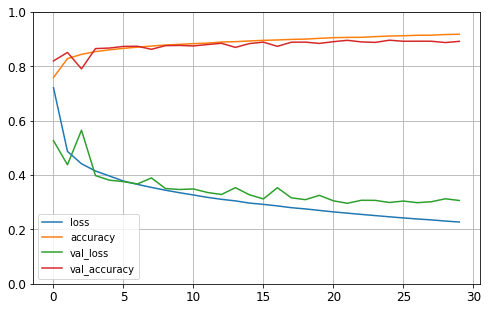

In [35]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.show()

In [36]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3440 - accuracy: 0.8827


[0.34396547079086304, 0.8827000260353088]

ㄴ 하이퍼파라미터를 튜닝한 곳이 검증 세트이기 때문에 검증 세트보다 테스트 세트에서 성능이 조금 낮은 것이 일반적

### 모델을 사용해 예측을 만들기
모델의 predict() 메서드를 사용해 새로운 샘플에 대한 예측을 만들 수 있음  
실제로 새로운 샘플이 없기 때문에 테스트 세트의 처음 3개 샘플을 사용

In [37]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.04, 0.  , 0.93],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [38]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [39]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [40]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

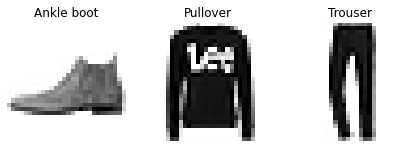

In [41]:
plt.figure(figsize=(7.2, 2.4))

for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

## 10.2.3 시퀀셜 API를 사용해 회귀용 다층 퍼셉트론 만들기

캘리포니아 주택 데이터셋

In [42]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

분류와의 주된 차이점은 출력층이 활성화 함수가 없는 하나의 뉴런(하나의 값을 예측)을 가진다는 것, 손실 함수로 평균 제곱 오차를 사용한다는 것

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

In [44]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 0s 847us/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 0s 899us/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 0s 993us/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 0s 814us/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 0s 832us/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 0s 831us/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 0s 915us/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4875 - va

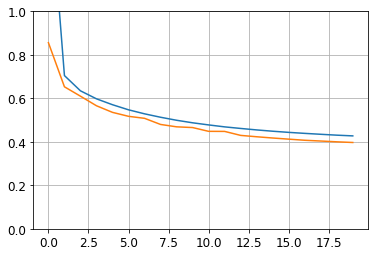

In [45]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [46]:
y_pred

array([[0.38856643],
       [1.6792021 ],
       [3.1022794 ]], dtype=float32)

## 10.2.4 함수형 API를 사용해 복잡한 모델 만들기

모든 신경망 모델이 단순하게 순서대로 나열되지는 않음  
어떤 신경망은 매우 복잡한 구조를 가짐. 여러 개의 입력이 있거나 여러 개의 출력이 있음.   
예를 들어 와이드 & 딥 신경망은 입력의 전체 또는 일부를 출력층에 바로 연결

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

In [49]:
# Input 객체, 한 모델은 여러 개의 입력을 가질 수 있음
input_ = keras.layers.Input(shape=X_train.shape[1:])

# 30개의 뉴런과 ReLU 활성화 함수를 가진 Dense 층을 만듦
# 이 층은 만들어지자마자 입력과 함께 함수처럼 호출됨. 이를 함수형 API라고 부르는 이유.
hidden1 = keras.layers.Dense(30, activation="relu")(input_)

# 두 번째 은닉층을 만들고 함수처럼 호출, 첫 번째 층의 출력을 전달했음
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

# concatenate 층을 만들고 또 다시 함수처럼 호출해 두 번째 은닉층의 출력과 입력을 연결
concat = keras.layers.concatenate([input_, hidden2])

# 하나의 뉴런과 활성화 함수가 없는 출력층을 만들고 Concatenate 층이 만든 결과를 사용해 호출
output = keras.layers.Dense(1)(concat)

# 사용할 입력과 출력을 지정해 케라스 Model을 만듦
model = keras.models.Model(inputs=[input_], outputs=[output])

In [50]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_2[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 38)           0           input_2[0][0]                    
                                                                 dense_6[0][0]              

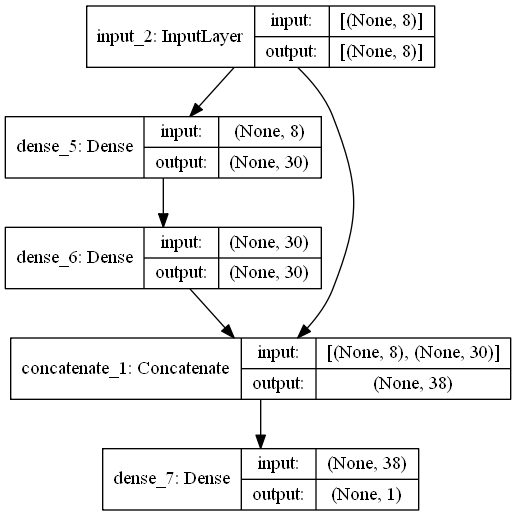

In [51]:
keras.utils.plot_model(model, "califonia_function_model.png", show_shapes=True)

In [52]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.6920 - val_loss: 0.8798
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6836 - val_loss: 0.6420
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6265 - val_loss: 0.5891
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5877 - val_loss: 0.5455
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5566 - val_loss: 0.5409
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5312 - val_loss: 0.4903
Epoch 7/20
363/363 [==============================] - 0s 979us/step - loss: 0.5108 - val_loss: 0.4728
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4952 - val_loss: 0.5017
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4802 - val_loss: 0.4511
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4685 - val_loss: 0.43

만약 일부 특성을 짧은 경로로 전달하고 다른 특성들은 깊은 경로로 전달하고 싶을 경우 한 가지 방법은 여러 입력을 사용하는 것

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

In [60]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [61]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 2.1486 - val_loss: 1.3943
Epoch 2/20
363/363 [==============================] - 0s 944us/step - loss: 0.8332 - val_loss: 0.8010
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7161 - val_loss: 0.7383
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6670 - val_loss: 0.6283
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6315 - val_loss: 0.5869
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6040 - val_loss: 0.5711
Epoch 7/20
363/363 [==============================] - 0s 989us/step - loss: 0.5809 - val_loss: 0.5447
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5616 - val_loss: 0.5179
Epoch 9/20
363/363 [==============================] - 0s 992us/step - loss: 0.5433 - val_loss: 0.5018
Epoch 10/20
363/363 [==============================] - 0s 965us/step - loss: 0.5275 - val_loss

In [62]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 30)           930         dense_10[0][0]                   
____________________________________________________________________________________________

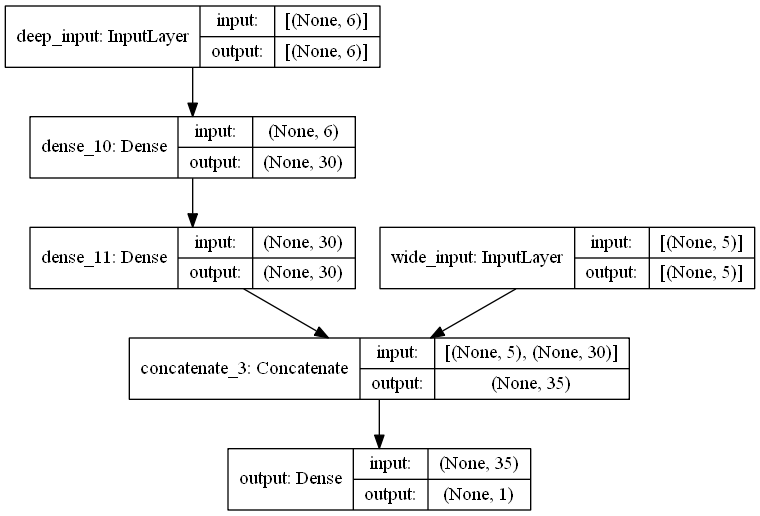

In [63]:
keras.utils.plot_model(model, "califonia_function_multi_model.png", show_shapes=True)

여러 개의 출력이 필요한 경우

In [64]:
np.random.seed(42)
tf.random.set_seed(42)

In [65]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

각 출력은 자신만의 손실함수가 필요  
따라서 모델을 컴파일할 때 손실의 리스트를 전달해야 함

In [66]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [67]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.1365 - main_output_loss: 1.9196 - aux_output_loss: 4.0890 - val_loss: 1.6233 - val_main_output_loss: 0.8468 - val_aux_output_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 0.8905 - main_output_loss: 0.6969 - aux_output_loss: 2.6326 - val_loss: 1.5163 - val_main_output_loss: 0.6836 - val_aux_output_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7429 - main_output_loss: 0.6088 - aux_output_loss: 1.9499 - val_loss: 1.4639 - val_main_output_loss: 0.6229 - val_aux_output_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6771 - main_output_loss: 0.5691 - aux_output_loss: 1.6485 - val_loss: 1.3388 - val_main_output_loss: 0.5481 - val_aux_output_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6381 - main_output_loss: 0.5434 - aux_output_loss: 1.4911 - val_loss

In [68]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 932us/step - loss: 0.4668 - main_output_loss: 0.4178 - aux_output_loss: 0.9082


## 10.2.5 서브클래싱 API로 동적 모델 만들기

반복문을 포함하고 다양한 크기를 다루거나 조건문을 가지는 등 여러 가지 동적인 구조의 모델을 필요로 함  
이런 경우 조금 더 명령형 프로그래밍 스타일이 필요하다면 서브클래싱 API가 정답

간단히 Model 클래스를 상속한 다음 생성자 안에서 필요한 층을 만듦  
그 다음 call() 메서드 안에 수행하려는 연산을 기술

In [69]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [70]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), 
                                                 (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 2.3298 - output_1_loss: 2.2186 - output_2_loss: 3.3304 - val_loss: 2.1435 - val_output_1_loss: 1.1581 - val_output_2_loss: 11.0117
Epoch 2/10
363/363 [==============================] - 1s 1ms/step - loss: 0.9714 - output_1_loss: 0.8543 - output_2_loss: 2.0252 - val_loss: 1.7567 - val_output_1_loss: 0.8205 - val_output_2_loss: 10.1825
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.8268 - output_1_loss: 0.7289 - output_2_loss: 1.7082 - val_loss: 1.5664 - val_output_1_loss: 0.7913 - val_output_2_loss: 8.5419
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7636 - output_1_loss: 0.6764 - output_2_loss: 1.5477 - val_loss: 1.3088 - val_output_1_loss: 0.6549 - val_output_2_loss: 7.1933
Epoch 5/10
363/363 [==============================] - 1s 1ms/step - loss: 0.7211 - output_1_loss: 0.6402 - output_2_loss: 1.4489 - val_loss: 1.1357 - val_output_1_loss: 0.5964 - val_

## 10.2.6 모델 저장과 복원

시퀀셜 API와 함수형 API를 사용하면 훈련된 케라스 모델을 저장하는 것은 매우 쉬움

In [72]:
np.random.seed(42)
tf.random.set_seed(42)

In [73]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [74]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 884us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 924us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 860us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 862us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 885us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 976us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 900us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 646us/step - loss: 0.4382


In [76]:
model.save("my_keras_model.h5")

In [77]:
model.predict(X_new)

array([[0.5400236],
       [1.6505971],
       [3.0098243]], dtype=float32)

In [78]:
model.save_weights("my_keras_weights.ckpt")

In [79]:
model.load_weights("my_keras_weights.ckpt")

## 10.2.7 콜백 사용하기

fir() 메서드의 callbacks 매개변수를 사용해 케라스가 훈련의 시작이나 끝에 호출할 객체 리스트를 지정할 수 있음

In [80]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [81]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

조기 종료 구현

In [82]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # 최상의 모델로 롤백
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 2s 3ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 1s 4ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 2s 4ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 1ms/step - loss: 0.4382


EarlyStopping 콜백을 사용해 조기 종료를 구현.  
일정 에포크 동안 검증 세트에 대한 점수가 향상되지 않으면 훈련을 멈춤.

In [83]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 2s 4ms/step - loss: 0.4393 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4315 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4259 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4201 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4154 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4111 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 2s 4ms/step - loss: 0.4074 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 2s 4ms/step - loss: 0.4040 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4008 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3976 - val_lo

363/363 [==============================] - 1s 2ms/step - loss: 0.3324 - val_loss: 0.3276
Epoch 82/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3320 - val_loss: 0.3167
Epoch 83/100
363/363 [==============================] - 2s 4ms/step - loss: 0.3317 - val_loss: 0.3281
Epoch 84/100
363/363 [==============================] - 2s 4ms/step - loss: 0.3312 - val_loss: 0.3636
Epoch 85/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3310 - val_loss: 0.3175
Epoch 86/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3308 - val_loss: 0.3156
Epoch 87/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3305 - val_loss: 0.3532
Epoch 88/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3299 - val_loss: 0.3256
Epoch 89/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3294 - val_loss: 0.3630
Epoch 90/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3296 - val_loss: 

더 많은 제어를 원한다면 사용자 정의 콜백을 만들 수 있음  
다음과 같은 사용자 정의 콜백은 훈련하는 동안 검증 손실과 훈련 손실의 비율을 출력

In [84]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [85]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

363/363 [==============================] - 1s 1ms/step - loss: 0.3302 - val_loss: 0.3559

val/train: 1.08


## 10.2.8 텐서보드를 사용해 시각화

In [86]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [87]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2021_10_17-12_02_32'

In [88]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [89]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [90]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 2s 4ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 2s 4ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 1s 4ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 1s 3ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 2s 4ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 1s 3ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 2s 4ms/step - loss: 0.4474 - val_loss: 0.4379

In [96]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 19404), started 0:02:51 ago. (Use '!kill 19404' to kill it.)

In [92]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2021_10_17-12_10_16'

In [93]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [94]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [95]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 2s 4ms/step - loss: 0.5530 - val_loss: 302.8466
Epoch 2/30
363/363 [==============================] - 1s 3ms/step - loss: 63.6669 - val_loss: 0.9735
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 0.9411 - val_loss: 0.9599
Epoch 4/30
363/363 [==============================] - 0s 1ms/step - loss: 0.9197 - val_loss: 0.8464
Epoch 5/30
363/363 [==============================] - 0s 1ms/step - loss: 0.9819 - val_loss: 0.9281
Epoch 6/30
363/363 [==============================] - 0s 1ms/step - loss: 0.9240 - val_loss: 0.9089
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 0.9179 - val_loss: 0.8815
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.8950 - val_loss: 0.9007
Epoch 9/30
363/363 [==============================] - 1s 3ms/step - loss: 0.9150 - val_loss: 0.8734
Epoch 10/30
363/363 [==============================] - 1s 3ms/step - loss: 0.8921 - val_loss: 0.8

In [97]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, write_steps_per_second=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# 10.3 신경망 하이퍼파라미터 튜닝하기

In [98]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

일반적인 사이킷런 추정기처럼 만들어 하이퍼파라미터 공간을 탐색하기 위해  
하이퍼파라미터로 케라스 모델을 만들고 컴파일 하는 함수를 만듦

In [99]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [100]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [101]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 1.0896 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.7606 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5456 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4732 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4503 - val_loss: 0.4188 - ETA: 0s - loss
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4338 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4241 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4168 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4108 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 1s 1ms/step - los

In [102]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 875us/step - loss: 0.3412


In [106]:
mse_test

-0.34119606018066406

In [103]:
y_pred = keras_reg.predict(X_new)

In [104]:
np.random.seed(42)
tf.random.set_seed(42)

모델 하나를 훈련하고 평가하는 것이 아닌 수백 개 모델을 훈련하고 최상의 모델을 선택해야 함  
하이퍼파라미터가 많으므로 그리드 탐색보다 랜덤 탐색을 사용하는 것이 좋음

In [107]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 0.8420 - val_loss: 0.4703
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4815 - val_loss: 0.4247
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4519 - val_loss: 0.4052
Epoch 4/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4429 - val_loss: 0.3975
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4368 - val_loss: 0.3991
Epoch 6/100
242/242 [==============================] - 1s 5ms/step - loss: 0.4340 - val_loss: 0.4031
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4351 - val_loss: 0.4043
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4267 - val_loss: 0.3929
Epoch 9/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4258 - val_loss: 0.4040
Epoch 10/100
242/242 [========

Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3678 - val_loss: 0.8462
Epoch 8/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3610 - val_loss: 0.8724
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3554 - val_loss: 0.9645
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3525 - val_loss: 0.7225
Epoch 11/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3475 - val_loss: 0.7257
Epoch 12/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3442 - val_loss: 0.7216
Epoch 13/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3422 - val_loss: 0.8440
Epoch 14/100
121/121 [==============================] - 0s 3ms/step - loss: 0.3650
[CV] END learning_rate=0.005432590230265343, n_hidden=2, n_neurons=94; total time=   7.9s
Epoch 1/100
242/242 [==============================] - 1s 2ms/step - loss: 1.0015 - val_loss: 2.9433
Epoch 2/100
242

242/242 [==============================] - 1s 3ms/step - loss: 0.5504 - val_loss: 0.5116
Epoch 28/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5453 - val_loss: 0.5076
Epoch 29/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5403 - val_loss: 0.5035
Epoch 30/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5356 - val_loss: 0.4989
Epoch 31/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5309 - val_loss: 0.4946
Epoch 32/100
242/242 [==============================] - 1s 5ms/step - loss: 0.5265 - val_loss: 0.4915
Epoch 33/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5222 - val_loss: 0.4883
Epoch 34/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5181 - val_loss: 0.4856
Epoch 35/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5141 - val_loss: 0.4828
Epoch 36/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5103 - val_loss: 

Epoch 16/100
242/242 [==============================] - 1s 5ms/step - loss: 0.6395 - val_loss: 1.5300
Epoch 17/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6303 - val_loss: 1.3410
Epoch 18/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6217 - val_loss: 1.1762
Epoch 19/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6133 - val_loss: 1.0345
Epoch 20/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6055 - val_loss: 0.9174
Epoch 21/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5980 - val_loss: 0.8153
Epoch 22/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5908 - val_loss: 0.7363
Epoch 23/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5839 - val_loss: 0.6696
Epoch 24/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5774 - val_loss: 0.6187
Epoch 25/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5711

Epoch 56/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4607 - val_loss: 0.4349
Epoch 57/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4588 - val_loss: 0.4330
Epoch 58/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4569 - val_loss: 0.4311
Epoch 59/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4550 - val_loss: 0.4291
Epoch 60/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4532 - val_loss: 0.4277
Epoch 61/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4515 - val_loss: 0.4257
Epoch 62/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4498 - val_loss: 0.4241
Epoch 63/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4482 - val_loss: 0.4224
Epoch 64/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4466 - val_loss: 0.4208
Epoch 65/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4451

Epoch 35/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3527 - val_loss: 0.3474
Epoch 36/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3508 - val_loss: 0.3944
Epoch 37/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3507 - val_loss: 0.4402
Epoch 38/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3502 - val_loss: 0.4723
Epoch 39/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3496 - val_loss: 0.3722
Epoch 40/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3481 - val_loss: 0.4019
Epoch 41/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3467 - val_loss: 0.3376
Epoch 42/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3449 - val_loss: 0.3377
Epoch 43/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3450 - val_loss: 0.3354
Epoch 44/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3433

242/242 [==============================] - 1s 4ms/step - loss: 0.3914 - val_loss: 0.3974
Epoch 19/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3887 - val_loss: 0.4229
Epoch 20/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3860 - val_loss: 0.4053
Epoch 21/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3840 - val_loss: 0.3989
Epoch 22/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3815 - val_loss: 0.3957
Epoch 23/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3793 - val_loss: 0.3864
Epoch 24/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3774 - val_loss: 0.4022
Epoch 25/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3756 - val_loss: 0.3729
Epoch 26/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3733 - val_loss: 0.3645
Epoch 27/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3716 - val_loss: 

242/242 [==============================] - 1s 4ms/step - loss: 4.2841 - val_loss: 559.4487
Epoch 22/100
121/121 [==============================] - 0s 1ms/step - loss: 0.6226
[CV] END learning_rate=0.01824796188192035, n_hidden=0, n_neurons=40; total time=  16.2s
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 1.2632 - val_loss: 1.4543
Epoch 2/100
242/242 [==============================] - 1s 5ms/step - loss: 0.6364 - val_loss: 0.9557
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5396 - val_loss: 0.4628
Epoch 4/100
242/242 [==============================] - 1s 5ms/step - loss: 0.4783 - val_loss: 0.4214
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4400 - val_loss: 0.3984
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4169 - val_loss: 0.4056
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4004 - val_loss: 0.3741
Epoch 8/100
242/242 [=========

Epoch 39/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3230 - val_loss: 0.3313
Epoch 40/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3194 - val_loss: 0.4033
Epoch 41/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3181 - val_loss: 0.3345
Epoch 42/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3165 - val_loss: 0.3650
Epoch 43/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3162 - val_loss: 0.3311
Epoch 44/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3147 - val_loss: 0.3684
Epoch 45/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3152 - val_loss: 0.3090
Epoch 46/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3128 - val_loss: 0.3821
Epoch 47/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3118 - val_loss: 0.3187
Epoch 48/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3118

Epoch 34/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3825 - val_loss: 0.3924
Epoch 35/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3815 - val_loss: 0.3611
Epoch 36/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3800 - val_loss: 0.4182
Epoch 37/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3792 - val_loss: 0.3539
Epoch 38/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3779 - val_loss: 0.4403
Epoch 39/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3769 - val_loss: 0.3551
Epoch 40/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3757 - val_loss: 0.4125
Epoch 41/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3748 - val_loss: 0.3665
Epoch 42/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3735 - val_loss: 0.3591
Epoch 43/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3730

Epoch 7/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3682 - val_loss: 0.3783
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3591 - val_loss: 0.4054
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3533 - val_loss: 0.3909
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3488 - val_loss: 0.3907
Epoch 11/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3445 - val_loss: 0.3554
Epoch 12/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3395 - val_loss: 0.3610
Epoch 13/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3352 - val_loss: 0.3665
Epoch 14/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3334 - val_loss: 0.3635
Epoch 15/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3294 - val_loss: 0.3581
Epoch 16/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3272 - 

Epoch 8/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3524 - val_loss: 0.7273
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3462 - val_loss: 0.9105
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3421 - val_loss: 0.6967
Epoch 11/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3364 - val_loss: 0.6960
Epoch 12/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3327 - val_loss: 0.7798
Epoch 13/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3293 - val_loss: 0.8549
Epoch 14/100
121/121 [==============================] - 0s 2ms/step - loss: 0.3525
[CV] END learning_rate=0.005803602934201024, n_hidden=3, n_neurons=74; total time=  11.5s
Epoch 1/100
242/242 [==============================] - 1s 3ms/step - loss: 0.9177 - val_loss: 0.9196
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4767 - val_loss: 2.1025
Epoch 3/100
242

242/242 [==============================] - 1s 4ms/step - loss: 0.3260 - val_loss: 0.3319
Epoch 15/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3217 - val_loss: 0.3482
Epoch 16/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3194 - val_loss: 0.3491
Epoch 17/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3172 - val_loss: 0.3249
Epoch 18/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3156 - val_loss: 0.3434
Epoch 19/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3123 - val_loss: 0.3348
Epoch 20/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3108 - val_loss: 0.3241
Epoch 21/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3086 - val_loss: 0.3745
Epoch 22/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3082 - val_loss: 0.3088
Epoch 23/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3047 - val_loss: 

242/242 [==============================] - 1s 5ms/step - loss: 0.3190 - val_loss: 0.3409
Epoch 21/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3179 - val_loss: 0.3752
Epoch 22/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3181 - val_loss: 0.3093
Epoch 23/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3147 - val_loss: 0.3417
Epoch 24/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3132 - val_loss: 0.3245
Epoch 25/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3099 - val_loss: 0.3051
Epoch 26/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3072 - val_loss: 0.3033
Epoch 27/100
242/242 [==============================] - 1s 5ms/step - loss: 0.3047 - val_loss: 0.4346
Epoch 28/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3079 - val_loss: 0.3420
Epoch 29/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3058 - val_loss: 

Epoch 63/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2985 - val_loss: 0.3085
Epoch 64/100
242/242 [==============================] - 1s 4ms/step - loss: 0.2963 - val_loss: 0.3977
Epoch 65/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2965 - val_loss: 0.2958
Epoch 66/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3032 - val_loss: 0.3222
Epoch 67/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2951 - val_loss: 0.3343
Epoch 68/100
242/242 [==============================] - 1s 5ms/step - loss: 0.2942 - val_loss: 0.3023
Epoch 69/100
242/242 [==============================] - 1s 4ms/step - loss: 0.2942 - val_loss: 0.3624
Epoch 70/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2968 - val_loss: 0.2944
Epoch 71/100
242/242 [==============================] - 0s 2ms/step - loss: 0.2921 - val_loss: 0.3878
Epoch 72/100
242/242 [==============================] - 1s 3ms/step - loss: 0.2922

Epoch 11/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3380 - val_loss: 0.5455
Epoch 12/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3368 - val_loss: 0.6470
Epoch 13/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3319 - val_loss: 0.3109
Epoch 14/100
363/363 [==============================] - 2s 4ms/step - loss: 0.3257 - val_loss: 0.3199
Epoch 15/100
363/363 [==============================] - 2s 4ms/step - loss: 0.3240 - val_loss: 0.3064
Epoch 16/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3203 - val_loss: 0.3244
Epoch 17/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3175 - val_loss: 0.3988
Epoch 18/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3153 - val_loss: 0.2991
Epoch 19/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3139 - val_loss: 0.3078
Epoch 20/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3112

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000016A63319EE0>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302,
                                                          0.007821074275112...
                                                          0.00502142573

랜덤 탐색이 찾은 최상의 하이퍼파라미터와 훈련된 케라스 모델을 얻을 수 있음

In [108]:
rnd_search_cv.best_params_

{'n_neurons': 74, 'n_hidden': 3, 'learning_rate': 0.005803602934201024}

In [109]:
rnd_search_cv.best_score_

-0.31833014885584515

In [110]:
rnd_search_cv.best_estimator_

In [111]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 830us/step - loss: 0.3029


-0.30288204550743103

In [112]:
model = rnd_search_cv.best_estimator_.model
model

In [113]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 918us/step - loss: 0.3029


0.30288204550743103